## RQ3: How do various factors influence the predominance of positive or negative evaluations in guest reviews for apartment-type Airbnb accommodations? 



In [2]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from IPython.display import display, HTML

In [3]:
# Load the listings and reviews data
listings = pd.read_csv('final_apartment_df.csv')
reviews = pd.read_csv('spelling_corrected_reviews.csv')
# Fix the column name
reviews.rename(columns=lambda x: x.strip(), inplace=True)


In [4]:
# Function to clean review text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

reviews['cleaned_review'] = reviews['comments'].apply(clean_text)

In [5]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

reviews['sentiment'] = reviews['comments'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews['sentiment_class'] = reviews['sentiment'].apply(classify_sentiment)

In [11]:
# Merge dataframes
merged_data = pd.merge(reviews, listings, on='listing_id')


In [40]:
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

merged_data['entities'] = merged_data['comments'].apply(extract_entities)

In [43]:
# Flatten the list of entities and count occurrences
all_entities = [entity for sublist in merged_data['entities'] for entity in sublist]
entity_counter = Counter([entity[0] for entity in all_entities if entity[1] == 'GPE'])  # Only consider GPE (geopolitical entities)

# Display the most common entities
common_entities = entity_counter.most_common(10)
print(common_entities)

[('kensington', 94), ('netflix', 90), ('richmond', 52), ('us', 48), ('liverpool', 34), ('anna', 27), ('paddington', 24), ('finsbury park', 24), ('india', 23), ('twickenham', 23)]


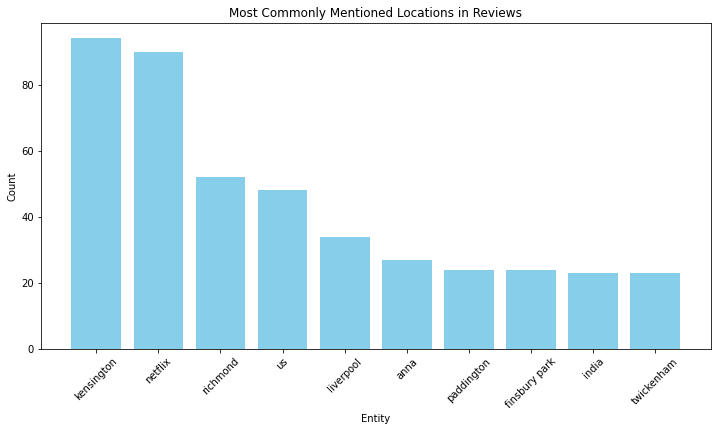

In [44]:
# Convert common entities to DataFrame for visualization
entity_df = pd.DataFrame(common_entities, columns=['Entity', 'Count'])

# Plot the most common entities
plt.figure(figsize=(12, 6))
plt.bar(entity_df['Entity'], entity_df['Count'], color='skyblue')
plt.title('Most Commonly Mentioned Locations in Reviews')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Apply customise lexicon dictionary 

#### VADER Sentiment Analysis
VADER is a lexicon and rule-based sentiment analysis tool specifically designed to analyze sentiments expressed in social media contexts. It computes a sentiment score by analyzing the input text and provides four scores:

- Positive: The proportion of text that is positive.
- Negative: The proportion of text that is negative.
- Neutral: The proportion of text that is neutral.
- Compound: A normalized, weighted composite score that ranges from -1 (most extreme negative) to +1 (most extreme positive).

#### Compound Score

The compound score is a single metric that calculates the overall sentiment of a text by combining the positive, negative, and neutral scores. It is a normalized score that lies between -1 and +1, where:

+1 represents the most positive sentiment.
-1 represents the most negative sentiment.

#### Why These Thresholds?
- Balance:

The thresholds of 0.05 and -0.05 are chosen to ensure that only texts with a clear positive or negative inclination are classified as such.
Texts with a compound score close to zero are likely to contain mixed or ambiguous sentiments, which are best classified as neutral.

Reference: https://www.researchgate.net/publication/350761338_A_Review_on_Lexicon-Based_and_Machine_Learning_Political_Sentiment_Analysis_Using_Tweets

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


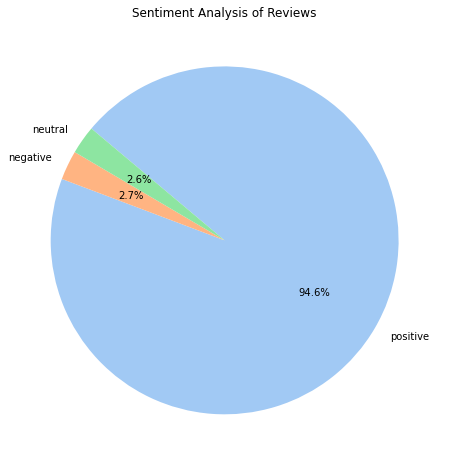

  Sentiment  Count
0  positive  31388
1  negative    905
2   neutral    876


In [25]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Load the dataset
language_reviews_path = 'spelling_corrected_reviews.csv'
language_custom_2 = pd.read_csv(language_reviews_path)

# Fix the column name
language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)

# Function to clean text and remove stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

# Apply text cleaning
language_custom_2['processed_comments'] = language_custom_2['comments'].apply(clean_text)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to classify comments as positive, negative, or neutral using VADER
def classify_sentiment_vader(text):
    score = sid.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'positive'
    elif score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis to the reviews DataFrame
language_custom_2['sentiment'] = language_custom_2['processed_comments'].apply(classify_sentiment_vader)

# Count how many reviews are positive, negative, and neutral
sentiment_counts = language_custom_2['sentiment'].value_counts()

# Plot pie chart with pastel colors
pastel_colors = sns.color_palette('pastel')
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=pastel_colors, counterclock=False)
plt.title('Sentiment Analysis of Reviews')
plt.show()

# Create summary DataFrame
summary_df = sentiment_counts.reset_index()
summary_df.columns = ['Sentiment', 'Count']

# Print the summary DataFrame
print(summary_df)


# 1. Sentiment Analysis #
## Sentiment Distribution by Host Type ##

The bar chart visualizes the distribution of sentiments (positive, negative, neutral) across different host types (normal hosts and super hosts).

Higher bars indicate a greater number of reviews.
Compare the heights of bars within the same sentiment category to see if one host type (host or super_host) consistently receives more positive, negative, or neutral reviews.

Identify Patterns:

If super hosts have a higher proportion of positive reviews, it suggests that guests tend to have a better experience with super hosts.
Conversely, if normal hosts have more negative reviews, it might indicate areas for improvement.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


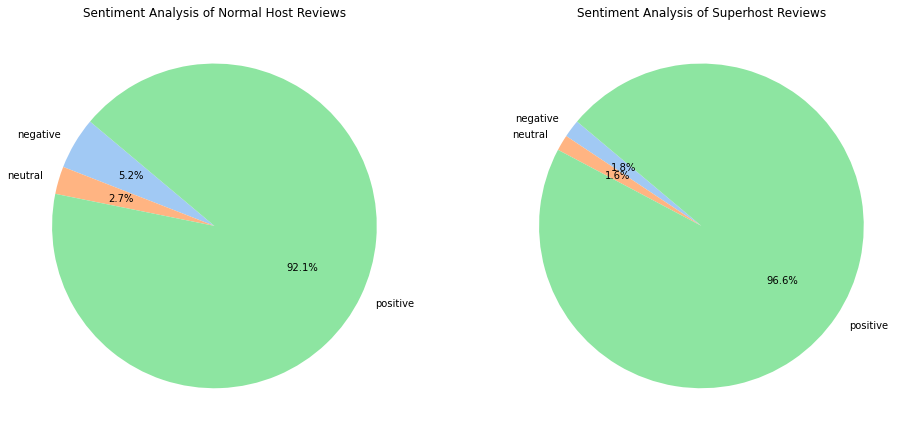

sentiment_class  negative  neutral  positive
host_type                                   
Normal Host          1215      643     21525
Superhost             174      154      9458


In [12]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re
import warnings
from spacy import displacy
from IPython.display import display, HTML

# Download VADER lexicon
nltk.download('vader_lexicon')

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Load the listings and reviews data
listings_2 = pd.read_csv('final_apartment_df.csv')
reviews_2 = pd.read_csv('spelling_corrected_reviews.csv')

# Fix the column name
reviews_2.rename(columns=lambda x: x.strip(), inplace=True)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

# Apply the sentiment analysis to the reviews DataFrame
reviews_2['sentiment'] = reviews_2['comments'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_2['sentiment_class'] = reviews_2['sentiment'].apply(classify_sentiment)

# Function to clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    return text

# Apply text cleaning
reviews_2['cleaned_comments'] = reviews_2['comments'].apply(clean_text)

# Apply NER to identify host mentions
def extract_hosts(text):
    doc = nlp(text)
    hosts = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    return hosts

reviews_2['hosts'] = reviews_2['cleaned_comments'].apply(extract_hosts)

# Ensure matching data types for merging
reviews_2['listing_id'] = reviews_2['listing_id'].astype(str)
listings_2['listing_id'] = listings_2['listing_id'].astype(str)

# Merge dataframes
merged_data = pd.merge(reviews_2, listings_2, on='listing_id')

# Identify host type (Superhost or normal host)
merged_data['host_type'] = merged_data['host_is_superhost'].apply(lambda x: 'Superhost' if x == 't' else 'Normal Host')

# Group data by host type and sentiment class
host_sentiments = merged_data.groupby(['host_type', 'sentiment_class']).size().unstack().fillna(0)

# Plot pie charts for each host type with pastel colors
pastel_colors = sns.color_palette('pastel')
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for ax, (host_type, counts) in zip(axs, host_sentiments.iterrows()):
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=pastel_colors)
    ax.set_title(f'Sentiment Analysis of {host_type} Reviews')

plt.show()

# Create summary DataFrame
summary_df = merged_data.groupby(['host_type', 'sentiment_class']).size().unstack().fillna(0)
print(summary_df)


#### Defintion

**Host** is anyone who lists their property (or a room within their property) on the platform for guests to book.

**Superhost** a host who has consistently provided exceptional hospitality and met specific criteria set by Airbnb.

- Completed at least 10 trips or 3 reservations that total at least 100 nights: This shows they have a good track record of hosting guests.
- Maintained a 90% response rate or higher: This indicates they are responsive to inquiries and concerns.
- Maintained a less than 1% cancellation rate: This demonstrates reliability and commitment to hosting.
- Maintained a 4.8 overall rating: This reflects high guest satisfaction with their hosting experience.

(Airbnb,n.d.)

In [16]:
# Split long sentences into shorter chunks for better visualization
def split_sentences(text, max_length=100):
    sentences = re.split(r'(?<=[.!?]) +', text)
    chunks = []
    current_chunk = ""
    for sentence in sentences:
        if len(current_chunk) + len(sentence) > max_length:
            chunks.append(current_chunk.strip())
            current_chunk = sentence
        else:
            current_chunk += " " + sentence
    if current_chunk:
        chunks.append(current_chunk.strip())
    return chunks

# Visualize dependency parse trees for a sample of reviews
for index, row in reviews_2.head(5).iterrows():
    chunks = split_sentences(row['comments'])
    for chunk in chunks:
        doc = nlp(chunk)
        displacy_output = displacy.render(doc, style='dep', jupyter=False, options={
            'distance': 120,  # Increase distance for readability
            'compact': False, 
            'bg': '#fafafa',  # Background color for better visibility
            'color': 'black',  # Text color
            'font': 'Arial'  # Font for better readability
        })
        display(HTML(f"<div style='width: 100%; overflow-x: auto;'>{displacy_output}</div>"))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


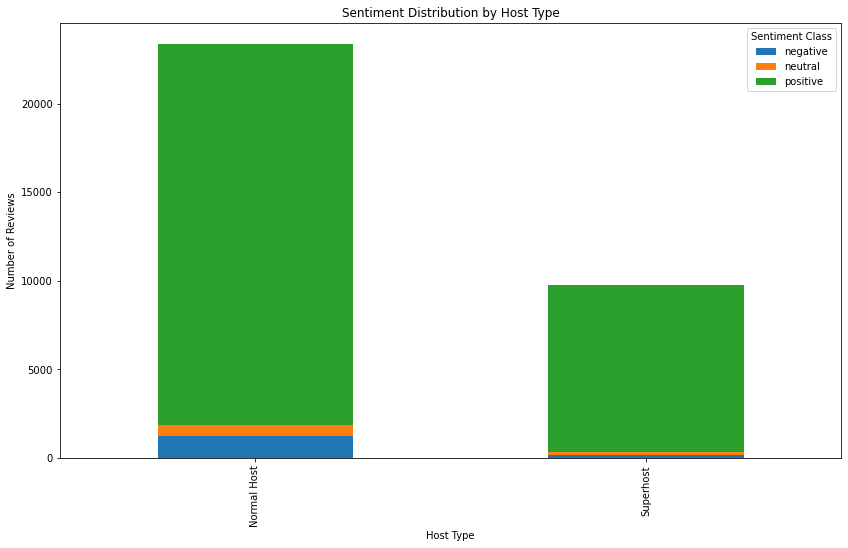

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re
import warnings
from spacy import displacy
from IPython.display import display, HTML

# Download VADER lexicon
nltk.download('vader_lexicon')

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Load the listings and reviews data
listings_2 = pd.read_csv('final_apartment_df.csv')
reviews_2 = pd.read_csv('spelling_corrected_reviews.csv')

# Fix the column name
reviews_2.rename(columns=lambda x: x.strip(), inplace=True)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

# Apply the sentiment analysis to the reviews DataFrame
reviews_2['sentiment'] = reviews_2['comments'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_2['sentiment_class'] = reviews_2['sentiment'].apply(classify_sentiment)

# Function to clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    return text

# Apply text cleaning
reviews_2['cleaned_comments'] = reviews_2['comments'].apply(clean_text)

# Apply NER to identify host mentions
def extract_hosts(text):
    doc = nlp(text)
    hosts = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    return hosts

reviews_2['hosts'] = reviews_2['cleaned_comments'].apply(extract_hosts)

# Ensure matching data types for merging
reviews_2['listing_id'] = reviews_2['listing_id'].astype(str)
listings_2['listing_id'] = listings_2['listing_id'].astype(str)

# Merge dataframes
merged_data = pd.merge(reviews_2, listings_2, on='listing_id')

# Identify host type (Superhost or normal host)
merged_data['host_type'] = merged_data['host_is_superhost'].apply(lambda x: 'Superhost' if x == 't' else 'Normal Host')

# Group data by host type and sentiment class
host_sentiments = merged_data.groupby(['host_type', 'sentiment_class']).size().unstack().fillna(0)

# Plot the data
host_sentiments.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Sentiment Distribution by Host Type')
plt.xlabel('Host Type')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment Class')
plt.show()

# Visualize dependency parse trees for a sample of reviews
for index, row in reviews_2.head(5).iterrows():
    doc = nlp(row['comments'])
    display(HTML(displacy.render(doc, style='dep', jupyter=False, options={'distance': 90})))


**Overall Interpretation:**

**Positive Review Dominance:** The overwhelming number of positive reviews for both hosts and super hosts indicates high guest satisfaction. The higher number of positive reviews for normal hosts could be due to a larger number of listings or more reviews overall.

**Super Hosts vs. Hosts:** Super hosts, despite having fewer total reviews, show a better ratio of positive to negative reviews compared to normal hosts. This suggests that super hosts are more likely to deliver consistently high-quality experiences.

**Negative Reviews:** The presence of negative reviews, though smaller in number, indicates areas where hosts and super hosts can improve. Super hosts having fewer negative reviews suggests they may be more responsive or proactive in addressing guest concerns.

**Actionable Insights:**

**For Hosts:**

Aim to understand and replicate the factors contributing to positive reviews.
Address the issues leading to negative reviews to improve overall ratings.

**For Super Hosts:**

Continue maintaining high standards to minimize negative reviews.
Use positive feedback to reinforce successful practices and enhance guest experiences.

**For Airbnb Platform:**

Provide resources and training for normal hosts to help them achieve super host status.
Encourage sharing of best practices among hosts to improve service quality across the platform.

## Sentiment by Type of Accommodation ##

-LDA ( Linear discriminant analysis)

In [29]:
# Topic Modelling with gensim
# Prepare data for LDA
text_data = merged_data['comments'].apply(lambda x: x.split())

# Create dictionary and corpus
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

# Build LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

# Visualize Topics with pyLDAvis.lda_model
# Visualize the topics
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

Topic: 0 
Words: 0.067*"the" + 0.048*"and" + 0.043*"to" + 0.034*"is" + 0.034*"a" + 0.019*"of" + 0.019*"very" + 0.018*"in" + 0.014*"for" + 0.013*"close"

Topic: 1 
Words: 0.062*"was" + 0.061*"and" + 0.041*"stay" + 0.035*"the" + 0.030*"to" + 0.028*"great" + 0.025*"a" + 0.024*"we" + 0.022*"would" + 0.020*"place"

Topic: 2 
Words: 0.080*"and" + 0.070*"very" + 0.046*"great" + 0.039*"location" + 0.033*"good" + 0.031*"clean" + 0.030*"a" + 0.028*"apartment" + 0.027*"is" + 0.023*"nice"

Topic: 3 
Words: 0.039*"the" + 0.037*"and" + 0.034*"to" + 0.023*"a" + 0.023*"i" + 0.018*"we" + 0.017*"for" + 0.016*"in" + 0.016*"of" + 0.014*"was"

Topic: 4 
Words: 0.082*"the" + 0.029*"was" + 0.028*"and" + 0.026*"a" + 0.022*"to" + 0.019*"it" + 0.017*"in" + 0.017*"is" + 0.015*"but" + 0.014*"we"



In [5]:
# Visualize Topics with pyLDAvis.lda_model for accomodation 
# Visualize the topics
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


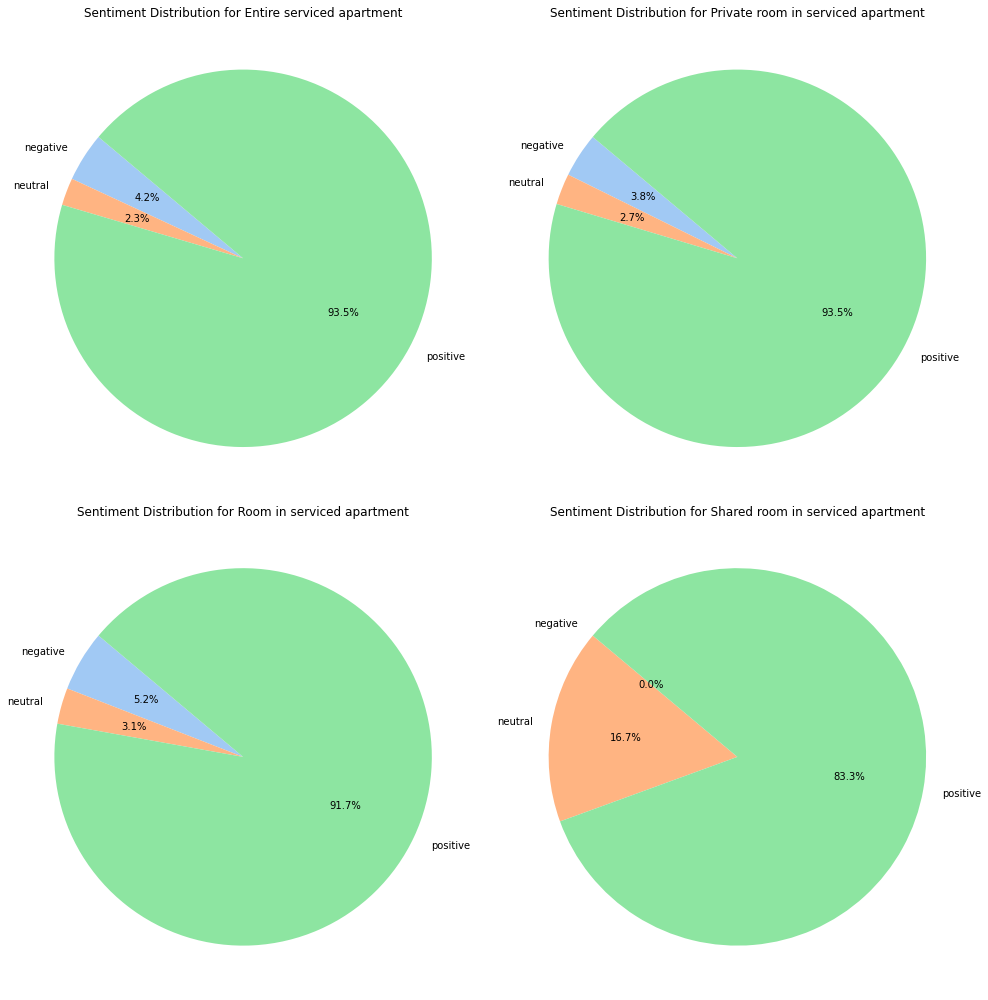

                        property_type  Number of Reviews
0           Entire serviced apartment              28553
1  Private room in serviced apartment               3573
2          Room in serviced apartment               1037
3   Shared room in serviced apartment                  6
Topic 0:
and was stay the a i we to great would
Topic 1:
the to was we and i in a were had
Topic 2:
the to and a is of station in onion close
Topic 3:
and very great was location the clean a apartment good
Topic 4:
the a and is it was in but of for


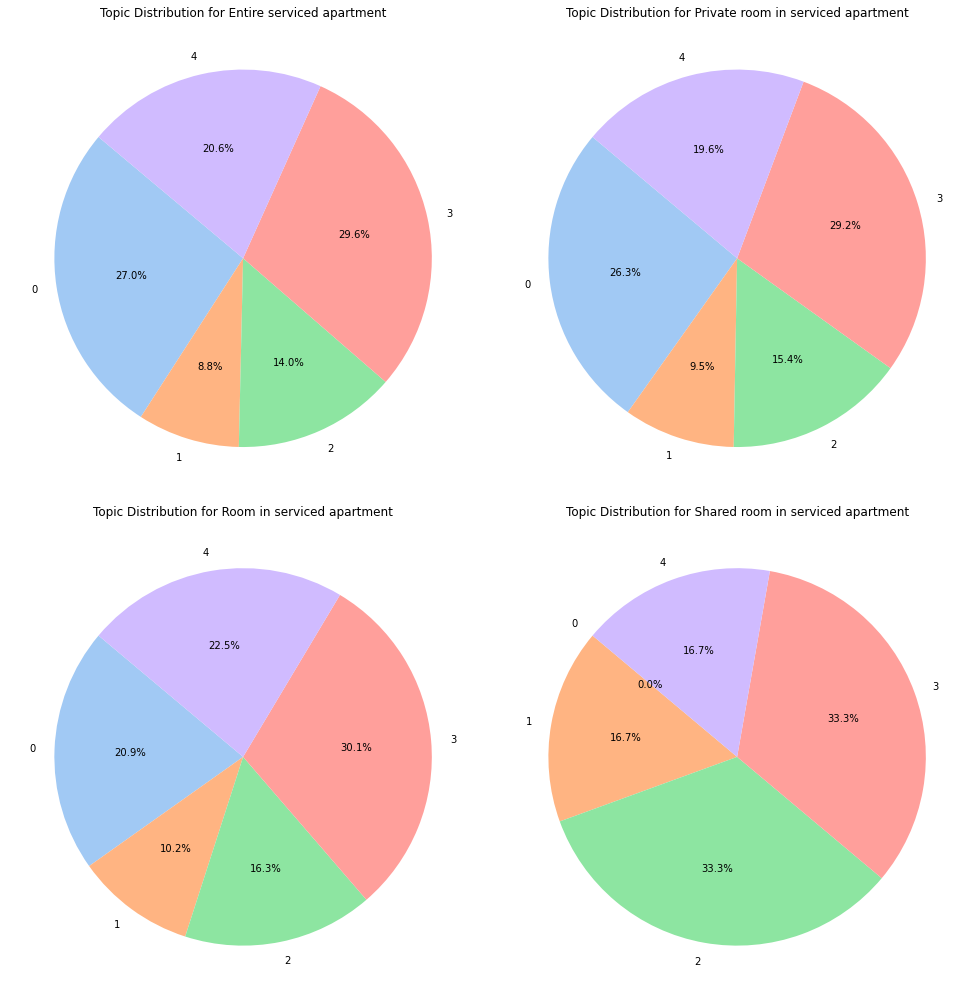

topic                                    0       1       2       3       4
property_type                                                             
Entire serviced apartment           7709.0  2499.0  3994.0  8464.0  5887.0
Private room in serviced apartment   939.0   341.0   550.0  1042.0   701.0
Room in serviced apartment           217.0   106.0   169.0   312.0   233.0
Shared room in serviced apartment      0.0     1.0     2.0     2.0     1.0


In [17]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import spacy
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

# Download VADER lexicon
nltk.download('vader_lexicon')

# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

# Load the listings and reviews data
listings_3 = pd.read_csv('final_apartment_df.csv')
reviews_3 = pd.read_csv('spelling_corrected_reviews.csv')

# Fix the column name
reviews_3.rename(columns=lambda x: x.strip(), inplace=True)

# Function to clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    return text

# Apply text cleaning
reviews_3['cleaned_comments'] = reviews_3['comments'].apply(clean_text)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

# Apply the sentiment analysis to the reviews DataFrame
reviews_3['sentiment'] = reviews_3['cleaned_comments'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_3['sentiment_class'] = reviews_3['sentiment'].apply(classify_sentiment)

# Ensure matching data types for merging
reviews_3['listing_id'] = reviews_3['listing_id'].astype(str)
listings_3['listing_id'] = listings_3['listing_id'].astype(str)

# Merge dataframes
merged_data = pd.merge(reviews_3, listings_3, on='listing_id')

# Filter necessary columns
merged_data = merged_data[['listing_id', 'cleaned_comments', 'sentiment_class', 'property_type']]

# Group data by property type and sentiment class
accommodation_sentiments = merged_data.groupby(['property_type', 'sentiment_class']).size().unstack().fillna(0)

# Plot pie charts for sentiment distribution by type of accommodation
property_types = accommodation_sentiments.index
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for ax, property_type in zip(axes, property_types):
    data = accommodation_sentiments.loc[property_type]
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    ax.set_title(f'Sentiment Distribution for {property_type}')

plt.tight_layout()
plt.show()

# Create summary DataFrame for review counts by property type
review_counts = merged_data.groupby('property_type').size().reset_index(name='Number of Reviews')
print(review_counts)

# Topic Modeling

# Use CountVectorizer to create the document-term matrix
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(merged_data['cleaned_comments'])

# Convert documents to list of tokens
tokenized_docs = [doc.split() for doc in merged_data['cleaned_comments']]

# Create a dictionary representation of the documents
dictionary = Dictionary(tokenized_docs)

# Create a corpus from the dictionary representation
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

# Fit LDA model to identify latent topics
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15, random_state=0)

# Display the top words for each topic
def display_topics(model, num_topics, num_words):
    for topic_idx, topic in model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
        print(f"Topic {topic_idx}:")
        print(" ".join([word for word, _ in topic]))

num_topics = 5
num_words = 10
display_topics(lda_model, num_topics, num_words)

# Visualize topics using pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

# Analyze topics by type of accommodation
merged_data['topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]

# Group data by property type and topic
accommodation_topics = merged_data.groupby(['property_type', 'topic']).size().unstack().fillna(0)

# Plot pie charts for topic distribution by type of accommodation
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

for ax, property_type in zip(axes, property_types):
    data = accommodation_topics.loc[property_type]
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    ax.set_title(f'Topic Distribution for {property_type}')

plt.tight_layout()
plt.show()

# Create summary DataFrame for topic counts by property type
topic_counts = merged_data.groupby('property_type')['topic'].value_counts().unstack().fillna(0)
print(topic_counts)


**Topic 0:**

Words: and was stay the a i we to great would

Interpretation: This topic seems to reflect general sentiments and experiences with staying at the accommodation. Words like "stay," "great," and "would" suggest overall satisfaction or quality of the stay.

**Topic 1:**

Words: the to was we and i in a were had

Interpretation: This topic appears to be more about narratives or experiences, given the presence of words like "we," "were," and "had." It could relate to personal stories or detailed experiences shared by reviewers.

**Topic 2:**

Words: the to and a is of station in onion close

Interpretation: The word "station" and "close" indicate this topic might relate to the location of the accommodation, specifically its proximity to public transportation or points of interest.

**Topic 3:**

Words: and very great was location the clean a apartment good

Interpretation: This topic is clearly about the attributes of the accommodation such as "location," "clean," and "apartment." Positive adjectives like "great" and "good" indicate that this topic likely reflects positive reviews about these attributes.

**Topic 4:**

Words: the a and is it was in but of for

Interpretation: This topic appears to be more generic and could be about the structure of the reviews themselves. Words like "but" suggest mixed sentiments where reviewers may have highlighted both positives and negatives.


## Sentiment by Neighbourhood ##
Objective: Apply NER and Topic Modelling to analyze sentiments for different neighbourhoods.

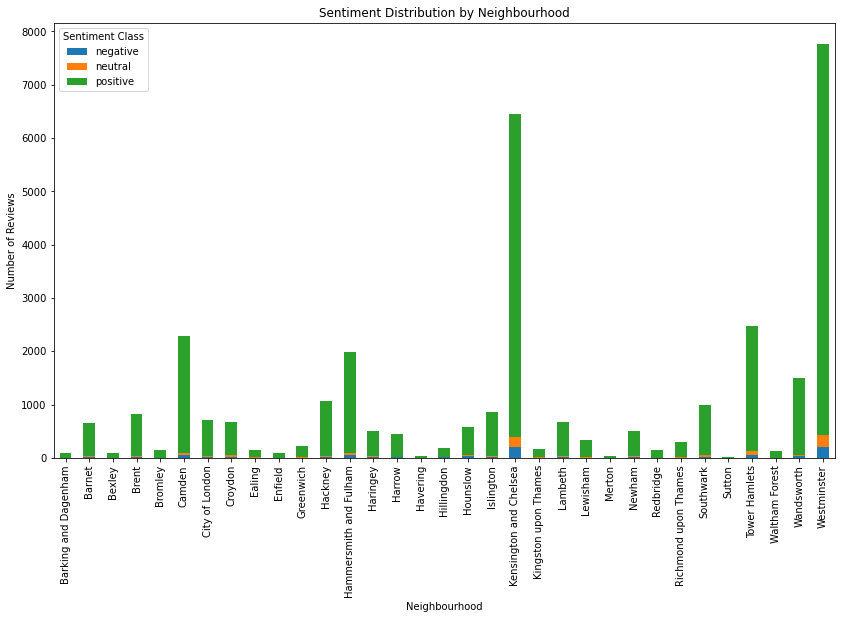

In [14]:
# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

# Apply the sentiment analysis to the reviews DataFrame
reviews['sentiment'] = reviews['cleaned_review'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews['sentiment_class'] = reviews['sentiment'].apply(classify_sentiment)

# Ensure matching data types for merging
reviews['listing_id'] = reviews['listing_id'].astype(str)
listings['listing_id'] = listings['listing_id'].astype(str)

# Merge dataframes
merged_data = pd.merge(reviews, listings, on='listing_id')

# Group data by neighbourhood_cleansed and sentiment class
neighbourhood_sentiments = merged_data.groupby(['neighbourhood_cleansed', 'sentiment_class']).size().unstack().fillna(0)

# Plot the data
neighbourhood_sentiments.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Sentiment Distribution by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment Class')
plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


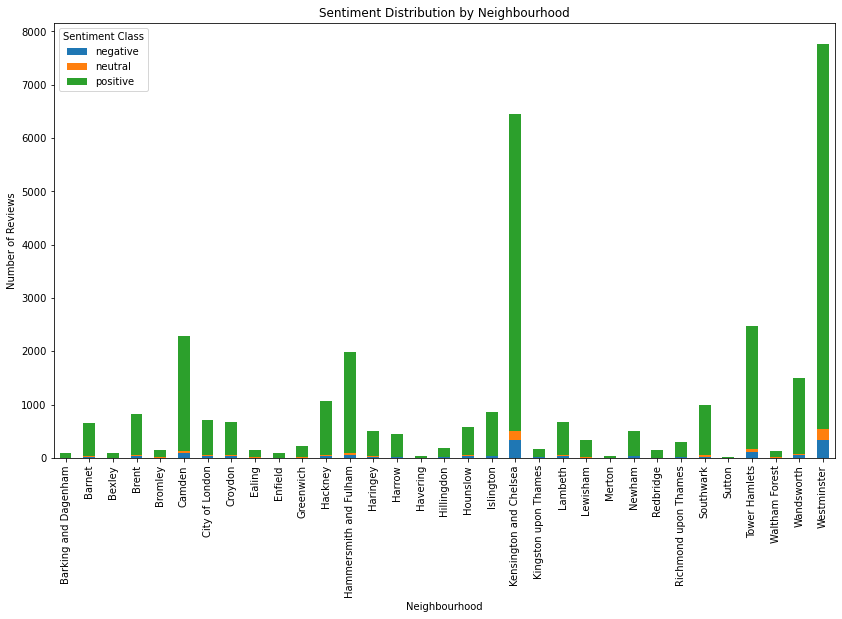

Topic 0:
br walk london street minutes park restaurants area away minute
Topic 1:
provided br london market attractions city tower green neighbourhood golders
Topic 2:
shopping mayfair london streets area located restaurants famous quiet street
Topic 3:
br london street city area restaurants shops vibrant station central
Topic 4:
london kensington br famous royal west area south park road


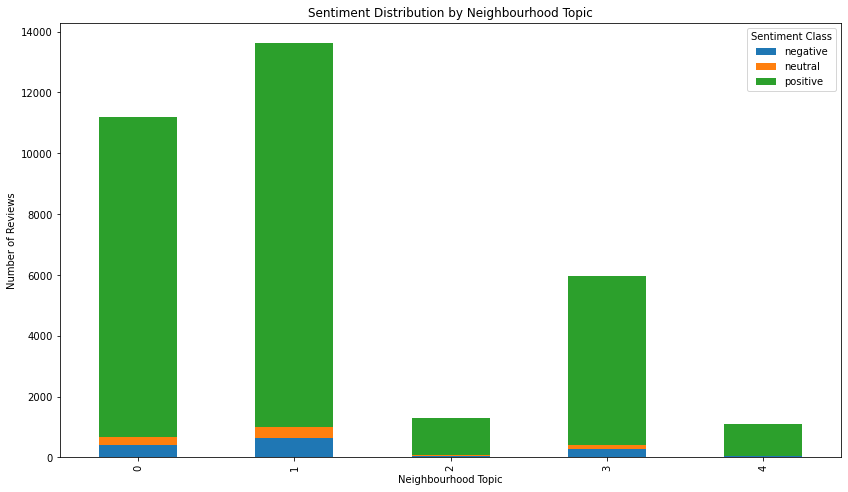

In [23]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download VADER lexicon
nltk.download('vader_lexicon')

# Load the listings and reviews data
listings_1 = pd.read_csv('final_apartment_df.csv')
reviews_1 = pd.read_csv('spelling_corrected_reviews.csv')

# Fix the column name
reviews_1.rename(columns=lambda x: x.strip(), inplace=True)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

# Apply the sentiment analysis to the reviews DataFrame
reviews_1['sentiment'] = reviews_1['comments'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_1['sentiment_class'] = reviews_1['sentiment'].apply(classify_sentiment)

# Ensure matching data types for merging
reviews_1['listing_id'] = reviews_1['listing_id'].astype(str)
listings_1['listing_id'] = listings_1['listing_id'].astype(str)

# Merge dataframes
merged_data = pd.merge(reviews_1, listings_1, on='listing_id')

# Group data by neighbourhood_cleansed and sentiment class
neighbourhood_sentiments = merged_data.groupby(['neighbourhood_cleansed', 'sentiment_class']).size().unstack().fillna(0)

# Plot the data
neighbourhood_sentiments.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Sentiment Distribution by Neighbourhood')
plt.xlabel('Neighbourhood')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment Class')
plt.show()

# Analyze Neighbourhood Overview
# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
neighbourhood_overview_matrix = vectorizer.fit_transform(listings_1['neighborhood_overview'].fillna(''))

# Apply LDA to extract topics
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(neighbourhood_overview_matrix)

# Display the topics
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, num_top_words)

# Merge LDA topics with neighbourhoods
topics = lda.transform(neighbourhood_overview_matrix)
listings_1['topic'] = topics.argmax(axis=1)

# Merge topic data with merged_data
merged_data = pd.merge(merged_data, listings_1[['listing_id', 'topic']], on='listing_id')

# Group data by topic and sentiment class
topic_sentiments = merged_data.groupby(['topic', 'sentiment_class']).size().unstack().fillna(0)

# Plot the data
topic_sentiments.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Sentiment Distribution by Neighbourhood Topic')
plt.xlabel('Neighbourhood Topic')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment Class')
plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Topic 0: br walk london street minutes park restaurants area away minute
Topic 1: provided br london market attractions city tower green neighbourhood golders
Topic 2: shopping mayfair london streets area located restaurants famous quiet street
Topic 3: br london street city area restaurants shops vibrant station central
Topic 4: london kensington br famous royal west area south park road


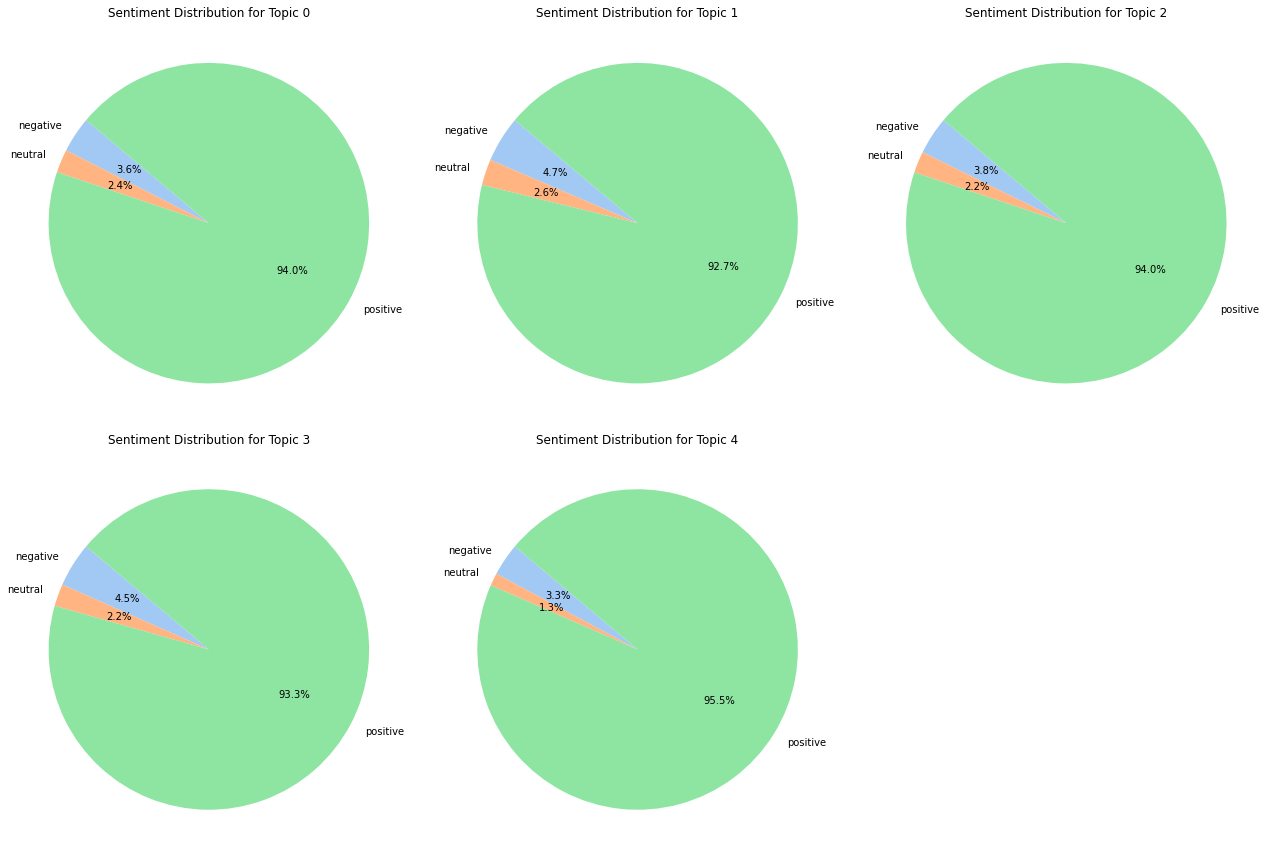

sentiment_class  negative  neutral  positive
topic                                       
0                     403      264     10530
1                     634      357     12627
2                      49       28      1211
3                     267      134      5566
4                      36       14      1049


In [18]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns

# Download VADER lexicon
nltk.download('vader_lexicon')

# Load the listings and reviews data
listings_1 = pd.read_csv('final_apartment_df.csv')
reviews_1 = pd.read_csv('spelling_corrected_reviews.csv')

# Fix the column name
reviews_1.rename(columns=lambda x: x.strip(), inplace=True)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to get sentiment score
def get_sentiment_score(text):
    return sid.polarity_scores(text)

# Apply the sentiment analysis to the reviews DataFrame
reviews_1['sentiment'] = reviews_1['comments'].apply(get_sentiment_score)

# Classify sentiments
def classify_sentiment(sentiment):
    if sentiment['compound'] > 0.05:
        return 'positive'
    elif sentiment['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

reviews_1['sentiment_class'] = reviews_1['sentiment'].apply(classify_sentiment)

# Ensure matching data types for merging
reviews_1['listing_id'] = reviews_1['listing_id'].astype(str)
listings_1['listing_id'] = listings_1['listing_id'].astype(str)

# Merge dataframes
merged_data = pd.merge(reviews_1, listings_1, on='listing_id')

# Analyze Neighbourhood Overview
# Vectorize the text data
vectorizer = CountVectorizer(stop_words='english')
neighbourhood_overview_matrix = vectorizer.fit_transform(listings_1['neighborhood_overview'].fillna(''))

# Apply LDA to extract topics
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(neighbourhood_overview_matrix)

# Display the topics
def display_topics(model, feature_names, num_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics.append(topic_words)
        print(f"Topic {topic_idx}: {' '.join(topic_words)}")
    return topics

num_top_words = 10
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, num_top_words)

# Merge LDA topics with neighbourhoods
topics_matrix = lda.transform(neighbourhood_overview_matrix)
listings_1['topic'] = topics_matrix.argmax(axis=1)

# Merge topic data with merged_data
merged_data = pd.merge(merged_data, listings_1[['listing_id', 'topic']], on='listing_id')

# Group data by topic and sentiment class
topic_sentiments = merged_data.groupby(['topic', 'sentiment_class']).size().unstack().fillna(0)

# Plot pie charts for each topic
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i in range(5):
    ax = axes[i]
    data = topic_sentiments.loc[i]
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    ax.set_title(f'Sentiment Distribution for Topic {i}')

# Remove the empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

# Create summary DataFrame for topic counts by sentiment
topic_counts = merged_data.groupby('topic')['sentiment_class'].value_counts().unstack().fillna(0)
print(topic_counts)


#### Insights from the Topics
#### Topic 0:

- Keywords: br, walk, london, street, minutes, park, restaurants, area, away, minute
- Interpretation: This topic seems to focus on the convenience and walkability of the neighborhood, highlighting proximity to parks and restaurants.

#### Topic 1:

- Keywords: provided, br, london, market, attractions, city, tower, green, neighbourhood, golders
- Interpretation: This topic is centered around the attractions and amenities provided in the neighborhood, including markets and green spaces.

#### Topic 2:

- Keywords: shopping, mayfair, london, streets, area, located, restaurants, famous, quiet, street
- Interpretation: This topic appears to focus on shopping areas, particularly in upscale neighborhoods like Mayfair, and mentions famous quiet streets and restaurants.

####  Topic 3:

- Keywords: br, london, street, city, area, restaurants, shops, vibrant, station, central
- Interpretation: This topic highlights vibrant city areas with restaurants, shops, and central locations near stations.

#### Topic 4:

- Keywords: london, kensington, br, famous, royal, west, area, south, park, road
- Interpretation: This topic discusses neighborhoods like Kensington and mentions famous landmarks, parks, and roads.

#### Actionable Recommendations

1. Marketing Strategies:

- Topic 0 (Walkability and Proximity):

Highlight the convenience and accessibility of neighborhoods, promoting the ease of walking to parks and restaurants.
Use customer testimonials that emphasize the convenience and pleasant walking experiences.

- Topic 1 (Attractions and Amenities):

Focus marketing efforts on promoting local attractions, markets, and green spaces.
Create packages or promotions that include visits to these attractions.

- Topic 2 (Shopping and Upscale Areas):

Target advertisements to highlight shopping experiences in upscale neighborhoods like Mayfair.
Collaborate with local shops and restaurants for promotional deals.

- Topic 3 (Vibrant City Areas):

Promote the vibrant lifestyle of central city areas with abundant restaurants and shops.
Use imagery and content that emphasize the lively and bustling nature of these neighborhoods.

- Topic 4 (Famous Landmarks and Parks):

Highlight the proximity to famous landmarks, parks, and the historical significance of areas like Kensington.
Promote guided tours or historical walks.

2. Trip Planning:

- Personalized Recommendations:

Use the sentiment analysis and topics to recommend neighborhoods that align with the customers' preferences and previous positive experiences.
For customers who appreciate walkability, suggest neighborhoods from Topic 0.

- Themed Itineraries:

Topic 0 : Walkability and Proximity
keywords: walk,street,minutes,park,restaurant,area,away,minute
Itinerary : "Explore on Foot"

Topic 1 : Attractions and Amenities 
keywords: market, attractions, city, tower, green, neighbourhood
Itinerary: "City Highlights"

Topic 2 : Shopping and Upscale Areas
Keywords: shopping, streets, area, restaurants, famous, quiet, street
Itinerary: "Shopping and Dining Extravaganza"

Topic 3 : Vibrant City Areas
Keywords: city, area, restaurants, shops, vibrant, station, central
Itinerary: "Urban Adventure" (Landmark)

Topic 4 : Historical and Cultural Landmarks
Keywords: famous, royal, west, area, south, park, road
Itinerary: "Historical and Cultural Exploration"
(Tour Historical Landmarks: Begin your day with a tour of famous historical landmarks. Visit royal palaces, historical buildings, and monuments.) 

- Customer Feedback:

Analyze reviews and feedback further to continuously refine and update recommendations.
Address any negative sentiments by investigating the underlying issues and improving the areas of concern.

In [19]:
# Topic Modelling by Neighbourhood
neighbourhoods = merged_data['neighbourhood_cleansed'].unique()

for neighbourhood in neighbourhoods:
    neighbourhood_reviews = merged_data[merged_data['neighbourhood_cleansed'] == neighbourhood]['comments']
    text_data = neighbourhood_reviews.apply(lambda x: x.split())
    
    # Check if text_data is not empty
    if text_data.empty or all(len(x) == 0 for x in text_data):
        print(f"No sufficient data for topic modeling in neighbourhood: {neighbourhood}")
        continue
    
    # Create dictionary and corpus
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    
    # Build LDA model
    if len(dictionary) == 0:
        print(f"No terms found for neighbourhood: {neighbourhood}")
        continue
    
    lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)
    
    # Print topics for the neighbourhood
    print(f'Topics for Neighbourhood: {neighbourhood}')
    for idx, topic in lda_model.print_topics(-1):
        print(f'Topic: {idx} \nWords: {topic}\n')
    
# Visualize Topics using pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)
    
    

Topics for Neighbourhood: Hammersmith and Fulham
Topic: 0 
Words: 0.039*"the" + 0.036*"to" + 0.029*"and" + 0.028*"is" + 0.025*"a" + 0.020*"i" + 0.016*"place" + 0.015*"it" + 0.013*"was" + 0.012*"for"

Topic: 1 
Words: 0.048*"i" + 0.013*"great" + 0.008*"location" + 0.006*"place" + 0.006*"no" + 0.005*"amazing" + 0.005*"comment" + 0.004*"you" + 0.003*"to" + 0.003*"for"

Topic: 2 
Words: 0.059*"and" + 0.042*"the" + 0.031*"was" + 0.028*"a" + 0.027*"to" + 0.026*"very" + 0.017*"stay" + 0.015*"in" + 0.015*"we" + 0.015*"for"

Topic: 3 
Words: 0.045*"and" + 0.041*"the" + 0.039*"a" + 0.032*"to" + 0.020*"in" + 0.018*"is" + 0.017*"was" + 0.016*"great" + 0.014*"with" + 0.014*"for"

Topic: 4 
Words: 0.077*"the" + 0.031*"and" + 0.027*"to" + 0.022*"was" + 0.020*"is" + 0.019*"a" + 0.017*"in" + 0.014*"i" + 0.014*"of" + 0.013*"it"

Topics for Neighbourhood: Richmond upon Thames
Topic: 0 
Words: 0.061*"the" + 0.040*"and" + 0.029*"a" + 0.025*"to" + 0.024*"was" + 0.021*"in" + 0.017*"for" + 0.017*"is" + 0.016*

Topics for Neighbourhood: Southwark
Topic: 0 
Words: 0.016*"and" + 0.012*"apartment" + 0.010*"great" + 0.010*"lovely" + 0.010*"a" + 0.008*"location" + 0.006*"beds" + 0.006*"accommodation" + 0.006*"in" + 0.005*"clean"

Topic: 1 
Words: 0.064*"the" + 0.045*"and" + 0.033*"was" + 0.027*"to" + 0.023*"a" + 0.015*"it" + 0.015*"very" + 0.015*"we" + 0.014*"is" + 0.013*"of"

Topic: 2 
Words: 0.068*"the" + 0.035*"and" + 0.028*"a" + 0.023*"is" + 0.021*"in" + 0.019*"to" + 0.019*"very" + 0.012*"apartment" + 0.012*"with" + 0.012*"was"

Topic: 3 
Words: 0.050*"the" + 0.041*"and" + 0.032*"a" + 0.027*"to" + 0.017*"was" + 0.016*"of" + 0.015*"is" + 0.015*"in" + 0.012*"with" + 0.012*"onion"

Topic: 4 
Words: 0.044*"and" + 0.035*"to" + 0.031*"the" + 0.030*"a" + 0.025*"great" + 0.025*"was" + 0.023*"stay" + 0.017*"for" + 0.016*"in" + 0.016*"location"

Topics for Neighbourhood: Haringey
Topic: 0 
Words: 0.081*"the" + 0.040*"and" + 0.030*"is" + 0.024*"to" + 0.023*"a" + 0.020*"was" + 0.015*"very" + 0.013*"in" + 

Topics for Neighbourhood: Harrow
Topic: 0 
Words: 0.057*"and" + 0.034*"the" + 0.029*"to" + 0.026*"was" + 0.017*"a" + 0.016*"in" + 0.015*"very" + 0.015*"for" + 0.014*"i" + 0.014*"stay"

Topic: 1 
Words: 0.038*"great" + 0.035*"place" + 0.032*"and" + 0.026*"stay" + 0.022*"location" + 0.020*"clean" + 0.018*"very" + 0.017*"lovely" + 0.016*"was" + 0.014*"the"

Topic: 2 
Words: 0.035*"and" + 0.024*"is" + 0.012*"good" + 0.012*"very" + 0.012*"gay" + 0.012*"everything" + 0.011*"are" + 0.011*"you" + 0.010*"clean" + 0.010*"roberta"

Topic: 3 
Words: 0.020*"they" + 0.018*"and" + 0.014*"to" + 0.009*"as" + 0.009*"the" + 0.007*"just" + 0.007*"me" + 0.006*"my" + 0.005*"with" + 0.005*"have"

Topic: 4 
Words: 0.051*"the" + 0.044*"and" + 0.033*"a" + 0.033*"to" + 0.024*"was" + 0.018*"we" + 0.017*"is" + 0.017*"very" + 0.015*"in" + 0.013*"for"

Topics for Neighbourhood: Bromley
Topic: 0 
Words: 0.065*"the" + 0.028*"and" + 0.022*"is" + 0.021*"was" + 0.019*"to" + 0.018*"a" + 0.015*"in" + 0.013*"very" + 0.012*"

In [38]:
# Visualize Topics using pyLDAvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)
    